In [1]:
import numpy as np
import pandas as pd

# データの取り込み

# import data
data = pd.read_csv(r"./gender-classifier-DFE-791531.csv",encoding='latin1')

# concat gender and description
data = pd.concat([data.gender,data.description],axis=1)

#drop nan values inplace
data.dropna(inplace=True,axis=0)
data = data.reset_index(drop=True)

In [2]:
import re

def remove_urls(text):
    
    urls = [g[0] for g in re.findall(r'((https?|ftp)(:\/\/[-_\.!~*\'()a-zA-Z0-9;\/?:\@&=\+\$,%#]+))', text)]
    
    for url in sorted(urls,key=lambda x:-len(x)):
    
        text = text.replace(url,'')
        
    return text

In [3]:
data.gender.loc[data.gender == 'male']   = 0
data.gender.loc[data.gender == 'female'] = 1
data.gender.loc[~(data.gender == 0) & ~(data.gender == 1)] = np.nan

data.description = data.description.map(remove_urls)

data.dropna(inplace=True,axis=0)
data = data.reset_index(drop=True)
data.gender = data.gender.astype(int)

In [4]:
# preprocessing
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
from collections import defaultdict,Counter

docs = []

w2i  = defaultdict(lambda : len(w2i))

mystopwords = stopwords.words('english') + ["i'm","rt"]

tokenizer = RegexpTokenizer("(?u)(?=[a-zA-Z])\\b[\w']{2,}\\b")

for text in data.description:

    tokens = tokenizer.tokenize(text)
    docs.append([w2i[w.lower()] for w in tokens if w.lower() not in mystopwords])

In [13]:
dim = len(w2i)

In [18]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    
    results = np.zeros((len(sequences), dimension))
    
    for i,sequences in enumerate(sequences):
        results[i, sequences] = 1.
    return results

x = vectorize_sequences(docs,dim)
y = np.asarray(data.gender.values).astype('float32')

In [20]:
# train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)

In [22]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [46]:
from keras import models
from keras import layers
from keras import optimizers
from keras import metrics
from keras import losses
from keras import regularizers

model = models.Sequential()
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                       activation='relu', input_shape=(dim,)))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                       activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

In [60]:
model = models.Sequential()
model.add(layers.Dense(4, activation='relu', input_shape=(dim,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

In [61]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val,y_val))

Train on 9074 samples, validate on 1000 samples
Epoch 1/20
9074/9074 [==============================] - 3s 354us/step - loss: 0.6932 - acc: 0.5040 - val_loss: 0.6933 - val_acc: 0.4840
Epoch 2/20
9074/9074 [==============================] - 3s 346us/step - loss: 0.6929 - acc: 0.5122 - val_loss: 0.6933 - val_acc: 0.4840
Epoch 3/20
9074/9074 [==============================] - 3s 364us/step - loss: 0.6926 - acc: 0.5141 - val_loss: 0.6932 - val_acc: 0.4840
Epoch 4/20
9074/9074 [==============================] - 3s 373us/step - loss: 0.6921 - acc: 0.5132 - val_loss: 0.6931 - val_acc: 0.4840
Epoch 5/20
9074/9074 [==============================] - 3s 374us/step - loss: 0.6913 - acc: 0.5134 - val_loss: 0.6928 - val_acc: 0.4840
Epoch 6/20
9074/9074 [==============================] - 3s 373us/step - loss: 0.6904 - acc: 0.5125 - val_loss: 0.6924 - val_acc: 0.4840
Epoch 7/20
9074/9074 [==============================] - 3s 384us/step - loss: 0.6899 - acc: 0.5122 - val_loss: 0.6919 - val_acc: 0.4840


In [62]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

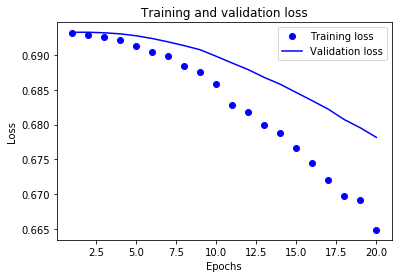

In [63]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

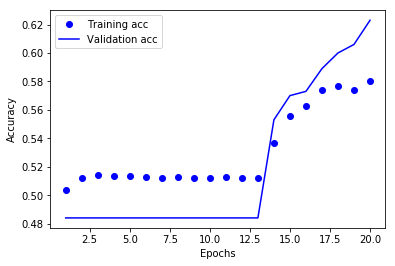

In [64]:
plt.clf()

acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [65]:
results = model.evaluate(x_test, y_test)

1120/1120 [==============================] - 0s 204us/step


In [66]:
results

[0.67419993707111903, 0.62857142857142856]